# Word Mover's distance

In this note notebook we will see an application of Optimal Transport to the problem of computing similarities between sentences and texts. The method under the lens is called 'Word Mover's Distance' in reference to 'Earth Mover's Distance', another name of the Wasserstein $1$ distance, mostly used in computer vision. 

Traditionnally, portions of texts are compared by Cosine similarity on bag-of-words vectors, i.e. histograms of occurences of words in a text. It captures the exact similarity in terms of words, but two very related sentences can be orthogonal if the words that are used have the same semantic but are different. Such a semantic distance can be obtained by using *word embeddings*, that are embeddings of words in a Euclidean space (of potentially large dimension) where the Euclidean distance have a semantic meaning: two related words will be close in such embeddings. A popular embedding is the *word2vec* embedding, obtained with neural networks. A study of those mechanisms is not in the scope of this notebook, but the interested reader can find more information on [the corresponding Wikipedia page](https://en.wikipedia.org/wiki/Word2vec). Throughout the rest of this tutorial, we will use a subset of the [GloVe](https://nlp.stanford.edu/projects/glove/) embedding.

The key observation made by Kusner and colleagues [1] is that when confronted to a sentence/document, the optimal transport distance can be used between histograms of occuring words using a ground metric obtained through word embeddings. In such a way, related words will be matched together, and the resulting distance will somehow express semantic relatedness between the content.

[1] Kusner, M., Sun, Y., Kolkin, N., & Weinberger, K. (2015, June). From word embeddings to document distances. In International Conference on Machine Learning (pp. 957-966). http://proceedings.mlr.press/v37/kusnerb15.pdf


## A basic example 

We will start by reproducing the Figure $1$ in the original paper

<img src="https://remi.flamary.com/cours/otml/fig1.png">

Two sentences are considered: 'Obama speaks to the media in Illinois' and 'The president greets the press in Chicago'. It is clear from this example that the Cosine similarity between the two sentences indicates that the two sentences are totally not related, since there is no word in common.  We will start by some imports and creating a list of the two sentences as words without stopwords that are not relevant for our analysis.

In [1]:
import os

import numpy as np
import matplotlib.pylab as pl
import ot


s1 = ['Obama','speaks','media','Illinois']
s2 = ['President','greets','press','Chicago']


We will use a subset of the GloVe word embedding, expressed as a dictionnary (word,embedding) that you can load this way

In [2]:
    
model=dict(np.load('data/model.npz'))
    

Then the embedded representation of the sentences can be obtained by

In [3]:
s1_embed = np.array([model[w] for w in s1])
s2_embed = np.array([model[w] for w in s2])

From the multidimensional scaling method in Scikitlearn, try to visualize the corresponding embedding of words in 2D.

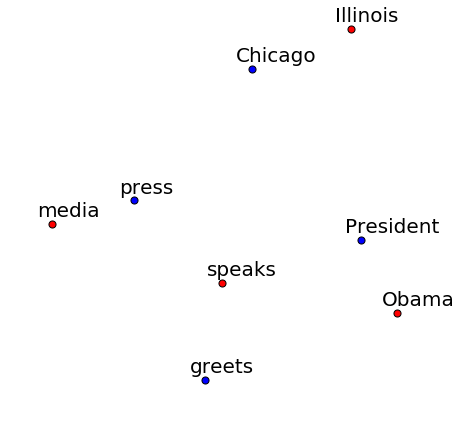

In [4]:
from sklearn import manifold

C = ot.dist(np.vstack((s1_embed,s2_embed)))

nmds = manifold.MDS(
        2,
        eps=1e-9,
        dissimilarity="precomputed",
        n_init=1)
npos = nmds.fit_transform(C)

pl.figure(figsize=(6,6))
pl.scatter(npos[:4,0],npos[:4,1],c='r',s=50, edgecolor = 'k')
for i, txt in enumerate(s1):
    pl.annotate(txt, (npos[i,0]-4,npos[i,1]+2),fontsize=20)
pl.scatter(npos[4:,0],npos[4:,1],c='b',s=50, edgecolor = 'k')
for i, txt in enumerate(s2):
    pl.annotate(txt, (npos[i+4,0]-4,npos[i+4,1]+2),fontsize=20)
pl.axis('off')
pl.tight_layout()
pl.show()

Let's now compute the coupling between those two distributions and visualize the corresponding result 


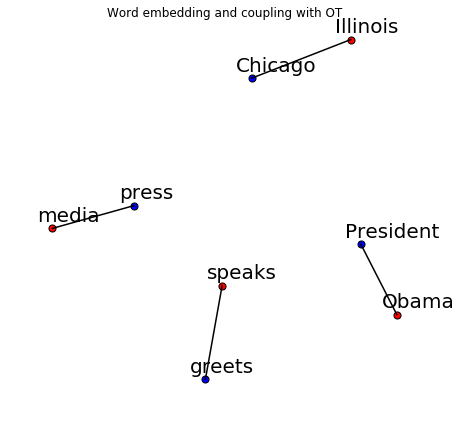

In [5]:
C2= ot.dist(s1_embed,s2_embed)
G=ot.emd(ot.unif(4),ot.unif(4),C2)

pl.figure(figsize=(6,6))
pl.scatter(npos[:4,0],npos[:4,1],c='r',s=50, edgecolor = 'k')
for i, txt in enumerate(s1):
    pl.annotate(txt, (npos[i,0]-4,npos[i,1]+2),fontsize=20)
pl.scatter(npos[4:,0],npos[4:,1],c='b',s=50, edgecolor = 'k')
for i, txt in enumerate(s2):
    pl.annotate(txt, (npos[i+4,0]-4,npos[i+4,1]+2),fontsize=20)
for i in range(G.shape[0]):
    for j in range(G.shape[1]):
        if G[i,j]>1e-5:
            pl.plot([npos[i,0],npos[j+4,0]],[npos[i,1],npos[j+4,1]],'k',alpha=G[i,j]/np.max(G))
pl.title('Word embedding and coupling with OT')
pl.axis('off')
pl.tight_layout()
pl.show()

## Sentence similarity
We will now explore the superiority of this Word mover distance (WMD) in a regression context, where our goal is to estimate the similarity (or relatedness) of two sentences on a scale of 0 to 5 (5 being the most similar). Given a set of pairs of sentences with a human annotated relatedness, our goal is predict the relatedness from a new pair of sentences.

We will use the [SICK (Sentences Involving Compositional Knowledge) dataset](http://clic.cimec.unitn.it/composes/sick.html) for this purpose.

We first load it.

In [6]:
   
data=np.load('data/data_text.npz')   
setA=data['setA']
setB=data['setB']
scores=data['scores']

print (setA[0])
print (setB[0])
print(scores[0])

np.savez('data/data_text.npz',setA=setA,setB=setB,scores=scores)


A group of kids is playing in a yard and an old man is standing in the background
A group of boys in a yard is playing and a man is standing in the background
4.5


We will only keep 200 sentences for learning our regression model and the rest for testing

In [7]:
n=200
testA=setA[n:]
trainA=setA[:n]
testB=setB[n:]
trainB=setB[:n]

scores_train=scores[:n]
scores_test=scores[n:]

Using the countVectorizer model from ScikitLearn, compute all the bag-of-words representations of the sentences

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vect = # TO BE FILLED

Build a big data matrix of all the words present in the dataset embeddings


In [9]:
all_feat = # TO BE FILLED

Compute a big matrix of all pairwise feature distances using the dist() method of POT

In [10]:
D = ot.dist(all_feat)

now you can write a code that will compute the Cosine and WMD dissimilarities from all the pairs of the training set 

In [11]:
X_cos=[]
X_wmd=[]
Y=[]



for i in range(len(trainA)):
    s1 = vect.transform([trainA[i]]).toarray().ravel()
    s2 = vect.transform([trainB[i]]).toarray().ravel()
    # Cosine similarity between bag of words
    d_cos=# TO BE FILLED
    X_cos.append(d_cos)
    # WMD
    d_wmd=# TO BE FILLED
    X_wmd.append(d_wmd)
    Y.append(scores_train[i])




Visualize the corresponding golden similarities / distance from the learning set. Hence you have a first appreciation of how much WMD better captures this similarity.

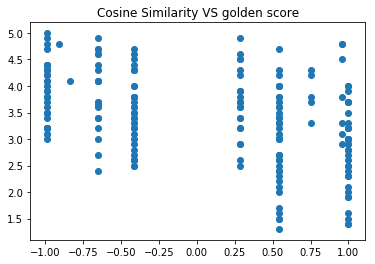

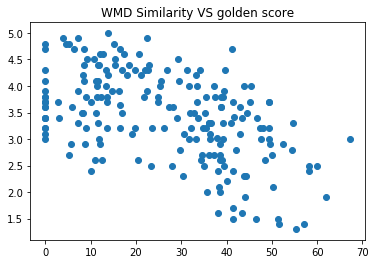

In [12]:
pl.figure()
pl.scatter(X_cos,Y)
pl.title('Cosine Similarity VS golden score')
pl.show()
pl.figure()
pl.scatter(X_wmd,Y)
pl.title('WMD Similarity VS golden score')
pl.show()


You can learn a simple regression model between those 2 quantities. Use a polynomial of degree 2 to learn the regression model.

In [13]:
import numpy.polynomial.polynomial as poly
k_cos = # TO BE FILLED
k_wmd = # TO BE FILLED

Now compute from your regression model the estimated relatedness for all the pairs in the test set.

In [14]:
X_cos=[]
X_wmd=[]
Y_test=[]
for i in range(len(testA)):
    s1 = vect.transform([testA[i]]).toarray().ravel()
    s2 = vect.transform([testB[i]]).toarray().ravel()
    # cosine similarity between bag of words
    d_cos=# TO BE FILLED
    X_cos.append(d_cos)
    # WMD
    d_wmd=# TO BE FILLED
    X_wmd.append(d_wmd)
    Y_test.append(scores_test[i])

# Final regression scores
Y_cos = # TO BE FILLED
Y_wmd = # TO BE FILLED

We will use MSE, Spearman's rho and Pearson coefficients to measure the quality of our regression model

In [15]:
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import pearsonr
from scipy.stats import spearmanr


Estimate the quality of your regression model for both Cosine and WMD dissimilarities

In [16]:
print('-------- Cosine')

pr = pearsonr(Y_cos, Y_test)[0]
sr = spearmanr(Y_cos,Y_test)[0]
se = mse(Y_cos,Y_test)

print('Test Pearson (test): ' + str(pr))
print('Test Spearman (test): ' + str(sr))
print('Test MSE (test): ' + str(se))

print('-------- WMD')

pr = pearsonr(Y_wmd, Y_test)[0]
sr = spearmanr(Y_wmd,Y_test)[0]
se = mse(Y_wmd,Y_test)

print('Test Pearson (test): ' + str(pr))
print('Test Spearman (test): ' + str(sr))
print('Test MSE (test): ' + str(se))

-------- Cosine
Test Pearson (test): 0.4391501309646927
Test Spearman (test): 0.36660337782004127
Test MSE (test): 0.8784692440428779
-------- WMD
Test Pearson (test): 0.7062364858939475
Test Spearman (test): 0.5872407398045967
Test MSE (test): 0.5858116558928291


Not bad isn't it ?